### 코드의 1번 ~ 4번까지는 이유한님의 블로그를 참고하여 작성하였음을 밝힙니다.
<https://kaggle-kr.tistory.com/17?category=868316>

## 성별, 나이, 이름 등의 데이터를 넣었을 때, 각 데이터의 Survived가 0이냐 1이냐를 예측


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 라이브러리 세팅
plt.style.use('seaborn')   # matplot 기본 그림 말고 seaborn 그림 스타일 사용
sns.set(font_scale=2.5)    # 폰트 사이즈 2.5로 고정

# null 데이터를 시각화하여 보여주는 라이브러리
import missingno as msno   

# 오류 무시하는 코드 
import warnings
warnings.filterwarnings('ignore')

# matplot 라이브러리 사용해 시각화한 뒤 show했을 때 새로운 창이 아닌 노트북에서 바로 확인 가능하도록
%matplotlib inline

## 1. 데이터 셋 확인
- 캐글 데이터 셋은 보통 train, test로 나뉘어져 있음

### 1.1 load data

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

### 1.2 train 데이터 확인

In [3]:
df_train.head()
# target label은 우리가 예측하려는 survived
# feature는 survived 제외한 나머지

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- survival - 생존유무, target 값. (0 = 사망, 1 = 생존)
- pclass - 티켓 클래스. (1 = 1st, 2 = 2nd, 3 = 3rd)
- sex - 성별
- Age - 나이(세)
- sibsp - 함께 탑승한 형제자매, 배우자 수 총합
- parch - 함께 탑승한 부모, 자녀 수 총합
- ticket - 티켓 넘버
- fare - 탑승 요금
- cabin - 객실 넘버
- embarked - 탑승 항구

In [4]:
df_train.shape

(891, 12)

In [5]:
df_train.info()

# pclass: ordinal (순서가 있는 카테고리형)
# sex: binary형이므로 나중에 수치형으로 바꿔줘야 함
# age: 연속적인 수치형
# ticket: 문자형
# fare: 연속적인 수치형
# embarked: 순서가 없는 카테고리형

# 카테고리형은 원 핫 인코딩으로 데이터 처리 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe()
# passengerid count는 행 개수인 891과 일치하는데 age는 714개임 -> null데이터가 존재한다는 것

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.3 test 데이터 확인

In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.4 null 데이터 개수 확인

In [10]:
df_train.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1.5 msno 라이브러리를 이용한 null 데이터 시각화

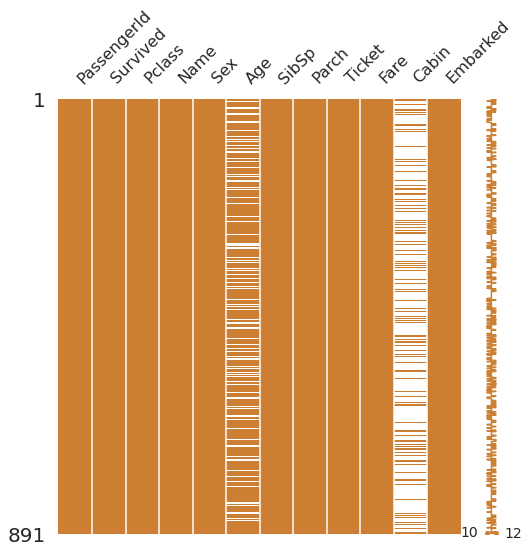

In [12]:
# matrix는 null값이 어디에 얼마나 촘촘하게 위치하는지를 알 수 있음
msno.matrix(df=df_train.iloc[:, :], figsize = (8,8), color=(0.8, 0.5, 0.2))

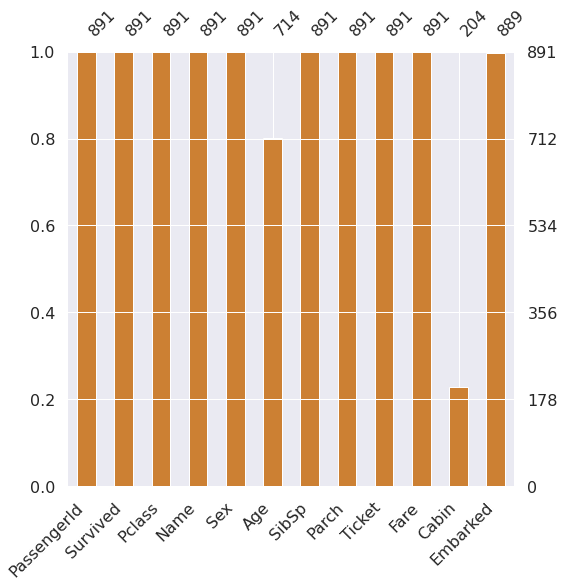

In [13]:
# bar는 null의 %를 알 수 있음
msno.bar(df=df_train.iloc[:, :], figsize = (8,8), color=(0.8, 0.5, 0.2))

## 2. 타겟 레이블 확인
- target label인 survived가 어떤 분포를 가지고 있는지 확인
  - 만약 100명 중 1명이 생존했는데 모델이 100명 모두 사망했다고 예측하면 모델 정확도는 99%
  - 우리의 목표는 생존을 예측하는 것이므로 사망자를 예측한 99%는 좋은 모델이 아님 (생존율은 0%이므로)
- survivied는 binary classification이므로 1과 0의 분포에 따라 모델의 평가 방법이 달라질 수 있음
- 즉, 데이터가 불균형이냐, 균형이냐에 따라 모델 평가 방법이 달라짐 

#### subplot과 subplots 
- subplot은 설정을 하나씩 해줘야하지만 subplots는 한번에 설정해 줄 수 있음
- 만약 100개의 그래프를 그린다면 subplot는 비효율적


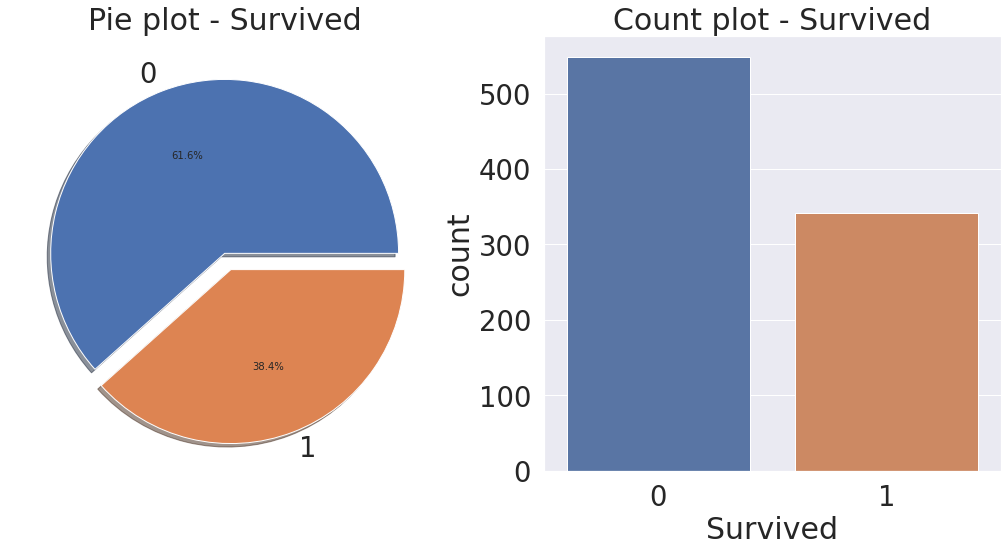

In [14]:
# fig: 전체 틀
# ax: 전체 틀안에 그려질 그래프 개수
fig, ax = plt.subplots(1, 2, figsize=(18, 8)) # 1줄에 2개 그래프 그림

# 첫번째 그래프 
df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
# df_train['Survived'].value_counts()는 시리즈타입이라 .plot하면 matplot과 연결됨
# explode=[0, 0.1]: 파이 조각 돌출크기로 0하면 돌출되지 않음. 0.1하면 돌출되어 튀어나옴
# autopct: 백분율로 %1.1f%%하면 소수점 1자리까지 %로 표기
# ax=ax[0]: 두가지 위치 중 첫번째 위치

# 첫번째 그래프 설정
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('') # y축 레이블 없앰

# 두번째 그래프
# countplot은 데이터프레임으로만 사용가능
sns.countplot('Survived', data=df_train, ax=ax[1])  # (x축에는 열, 사용할 데이터, 두번째 위치)

# 두번째 그래프 설정
ax[1].set_title('Count plot - Survived')

plt.show()

# 사망자 0이 61%, 생존자 1이 38.4% -> 타겟 레이블의 분포가 제법 균일함

## 3. 탐색적 데이터 분석(EDA)
- 각 데이터 간의 관계를 시각화하여 모델에서 사용할 피처 선택



### 3.1 pclass에 따른 survived

#### Pclass, Survived를 pclass로 그루핑한 뒤, count하여 0과 1의 개수를 구하면 pclass별 생존자 수를 구할 수 있음
- count, sum, mean의 차이


In [15]:
df_train[['Pclass', 'Survived']].groupby(['Pclass']).count() 
# count는 행 개수를 세므로 각 클래스의 인원을 알 수 있음 (칼럼이름이 survived이지 생존자가 아님)

,Survived
Pclass,
1,216
2,184
3,491


In [16]:
df_train[['Pclass', 'Survived']].groupby(['Pclass']).sum()
# sum을 하면 생존자인 1을 모두 더하므로 1등급 인원 중에 몇 명이 살았는지 알 수 있음 (216명 중 136명 생존)

,Survived
Pclass,
1,136
2,87
3,119


In [17]:
df_train[['Pclass', 'Survived']].groupby(['Pclass']).mean()
# mean을 하면 각 클래스별 생존율을 구할 수 있음

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


#### pandas의 crosstab을 사용하여 시각화

In [18]:
# margins=True는 합계인 All 표시
# .style.background_gradient(cmap='summer_r'): 숫자 크기에 따른 색깔표시(cmap은 컬러맵)   
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')  

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


#### bar를 사용하여 시각화

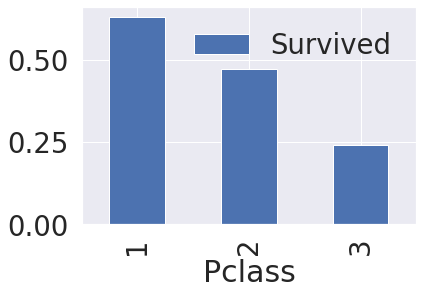

In [19]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()  
# as_index=True하면 pclass를 인덱스로 두므로 pclass와 survived 칼럼 모두 시각화 됨
# 클래스가 높을수록 생존율이 높은 것을 알 수 있음

#### seaborn의 countplot을 사용하여 시각화

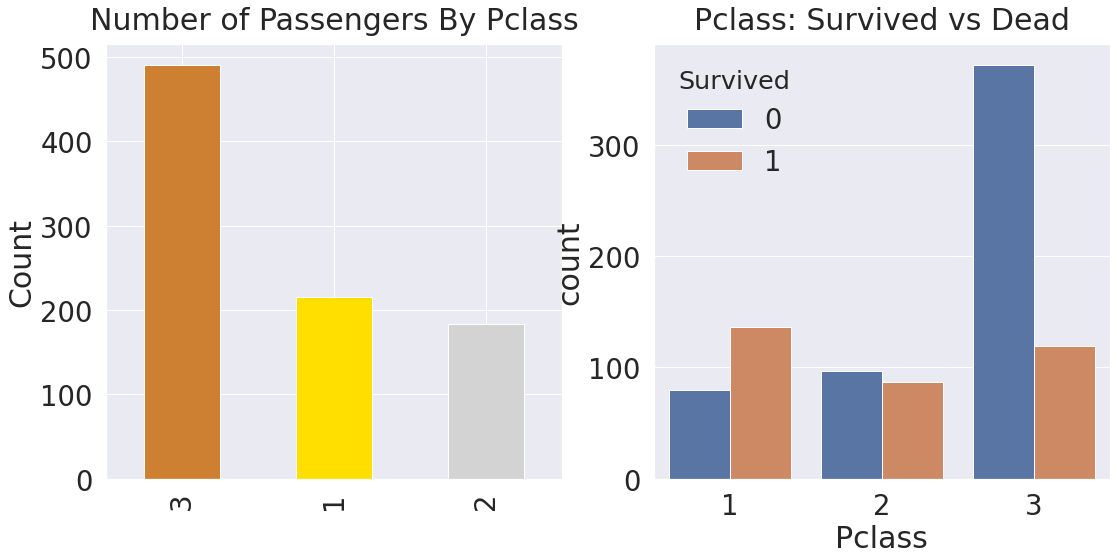

In [20]:
y_position = 1.02
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# 첫번째 그래프
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])

# 제목, y축 설정
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')

# 두번째 그래프
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1]) # hue='Survived'하면 생존,사망별로 색깔 나눔

# 제목 설정
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)

plt.show()

# 왼쪽 그래프는 클래스별 승객수로 3등급 승객이 가장 많음
# 오른쪽 그래프에서 각 클래스별 생존자를 보면 티켓 등급이 높을수록 생존자가 많음
# 클래스에 따라 생존율이 달라진다는 것을 확인했으므로 pclass피처는 모델에 사용하기 좋은 칼럼임을 확인

### 3.2 sex에 따른 survived

In [21]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [22]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins = True).style.background_gradient(cmap = 'summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


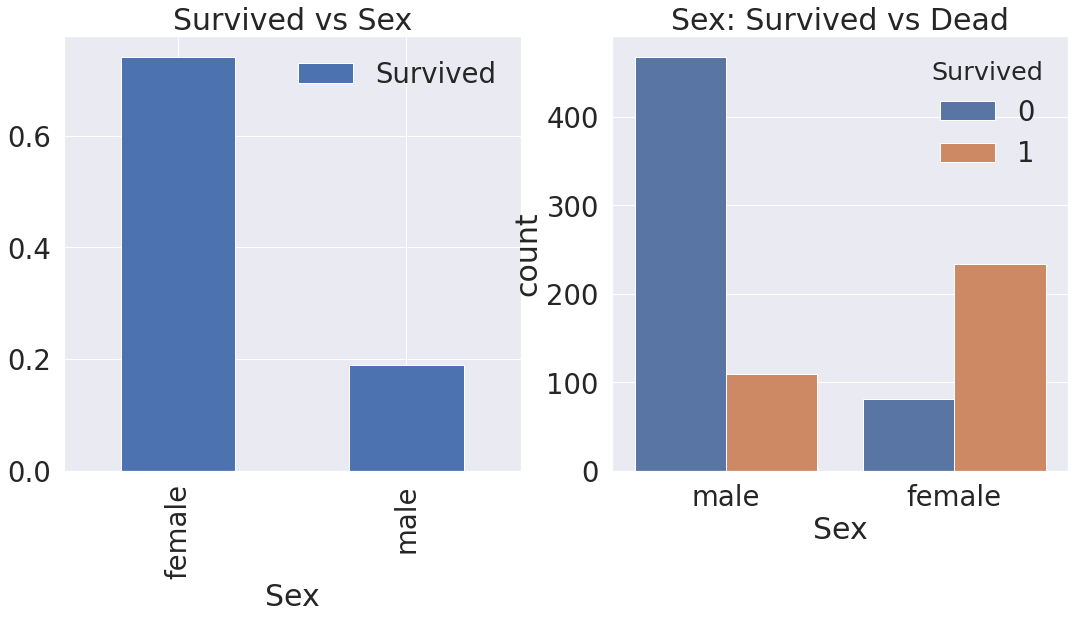

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# 첫번째 그래프
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])

# 제목 설정
ax[0].set_title('Survived vs Sex')

# 두번째 그래프
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])

# 제목 설정
ax[1].set_title('Sex: Survived vs Dead')

plt.show()

# 남자보다 여자의 생존율이 더 높음

### 3.3 sex, pclass에 따른 survived
- 성별과 클래스에 따른 생존율로 3가지 피처이니 3차원
- seaborn의 factorplot을 이용하면 3차원 그래프 그릴 수 있음

#### 등급별 생존율을 성별기준으로 나타냄

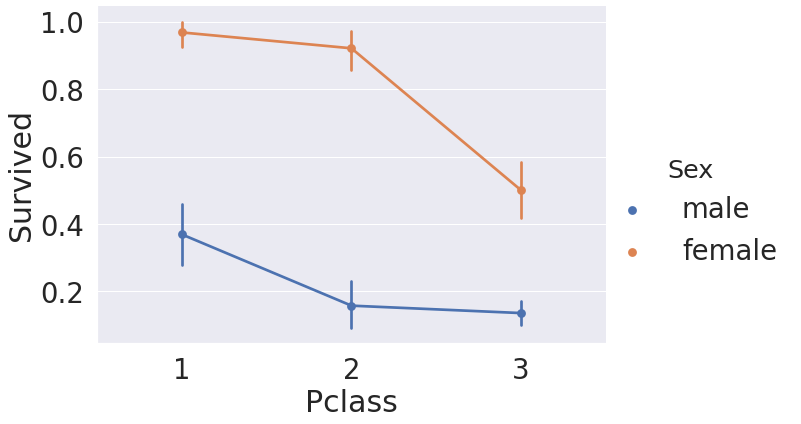

In [24]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)  # pclass x축, survived y축, aspect는 높이를 일정하게 유지하면서 너비 변경 
# 모든 클래스에서 남자보다 여자가 살 확률이 높음
# 또한 남녀 상관없이 클래스가 높으면 살 확률이 높음

#### 성별 생존율을 등급기준으로 나타냄
- 위 그래프처럼 hue = sex대신 column=pclass로 설정해 봄
   - hue: 한 그래프에 3개의 등급을 보여줌
   - column: 한 그래프에 1개의 등급을 보여줌

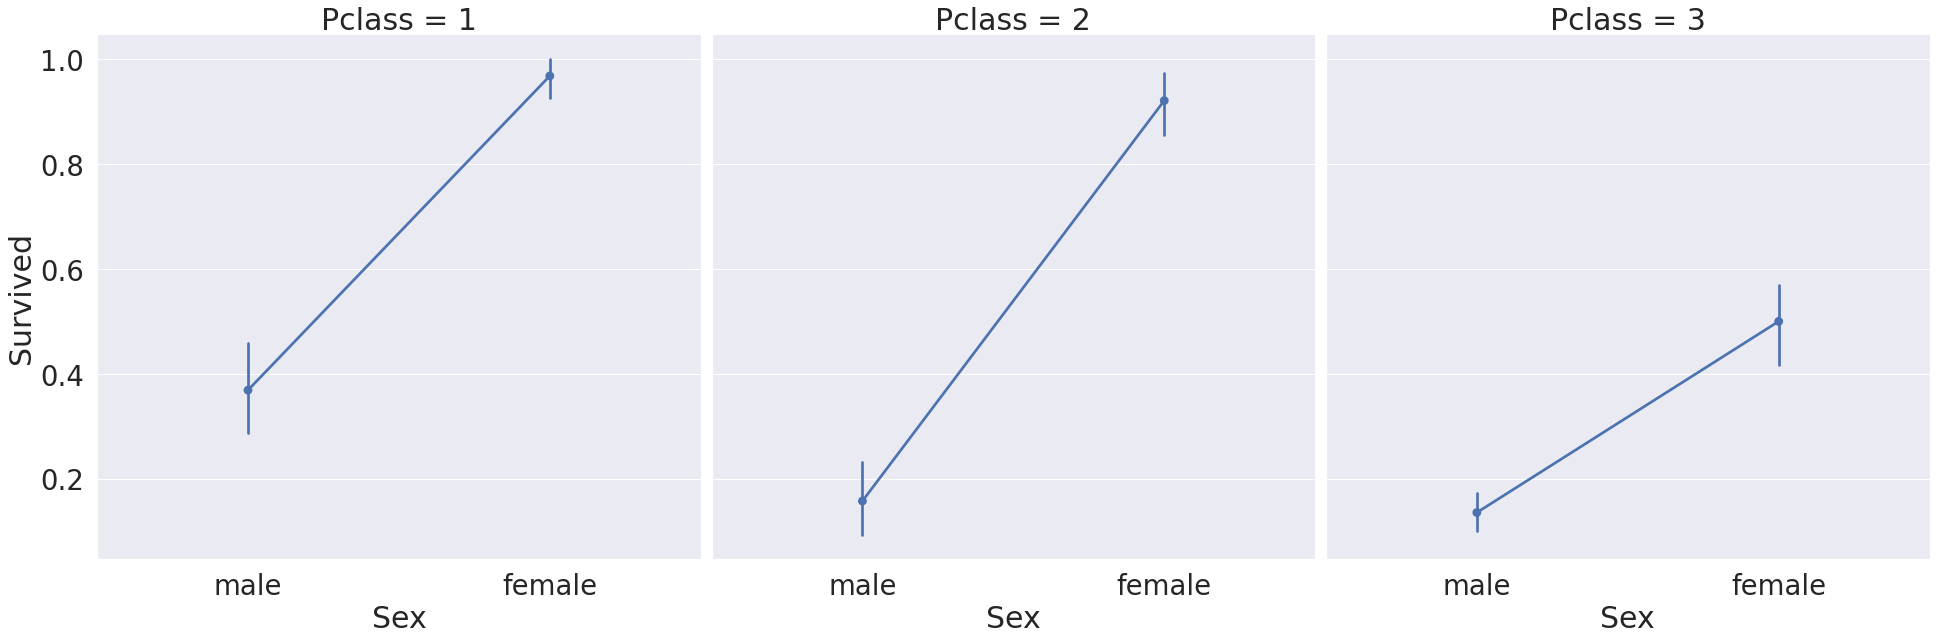

In [25]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, satureation=.5, size=9, aspect=1)

### 3.4 age에 따른 survived

In [26]:
print(df_train['Age'].max())  # 최고 나이
print(df_train['Age'].min())  # 최저 나이
print(df_train['Age'].mean()) # 평균 나이

80.0
0.42
29.69911764705882


#### 3.4.1 age별 survived 확인

- KDE로 데이터들의 분포를 알아봄 -> hist를 부드럽게 선으로 나타내줌

In [27]:
df_train[df_train['Survived'] == 1]['Age']  # 생존자인 사람의 나이 출력

1      38.0
2      26.0
3      35.0
8      27.0
9      14.0
       ... 
875    15.0
879    56.0
880    25.0
887    19.0
889    26.0
Name: Age, Length: 342, dtype: float64

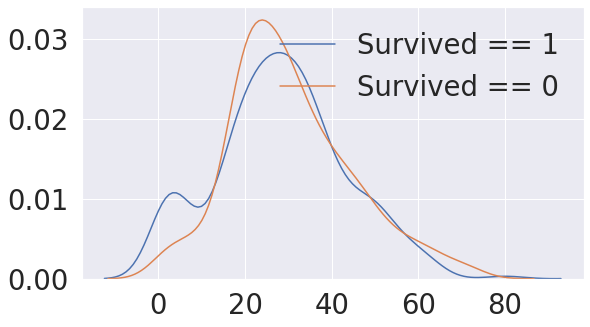

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

# KDE
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)

# 레이블 설정
plt.legend(['Survived == 1', 'Survived == 0'])

plt.show()

# 생존자에 나이어린 승객이 꽤 있음을 알 수 있음

#### 3.4.2 age별 class 확인

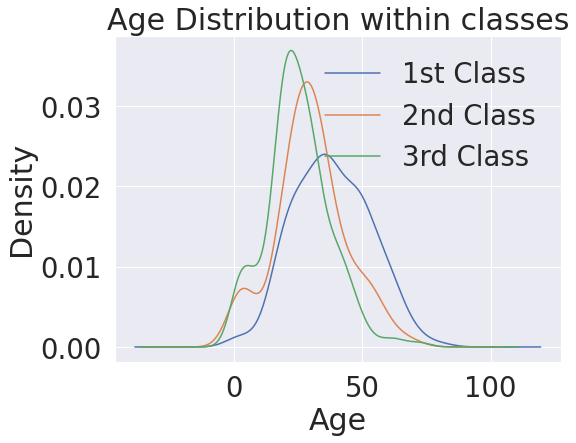

In [29]:
plt.figure(figsize=(8, 6))

# KDE
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

# 설정
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

# 클래스가 높을수록 나이 많은 사람의 비중이 커짐

### 3.5 pclass, sex, age에 따른 survived
- 지금까지 살펴본 3개의 피처 간 관계성을 보기위해 seaborn의 violinplot 사용

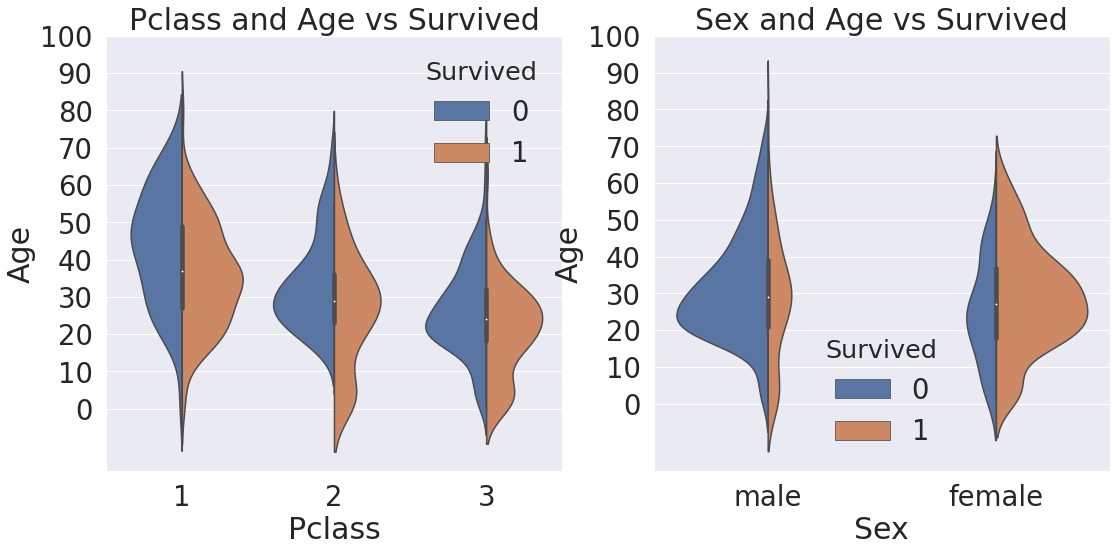

In [30]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

# 첫번째 그래프
sns.violinplot("Pclass", "Age", hue = "Survived", data = df_train, sclae = 'count', split=True, ax=ax[0])

# 설정
ax[0].set_title("Pclass and Age vs Survived")
ax[0].set_yticks(range(0,110,10))

# 두번째 그래프
sns.violinplot("Sex", "Age", hue="Survived", data = df_train, scale='count', split=True,ax=ax[1])

# 설정
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

# 왼쪽 그래프는 등급별 나이 분포와 그에 따른 생존여부를 나타냄
# 오른쪽 그래프는 성별별 나이 분포와 그에 따른 생존여부를 나타냄
# 모든 클래스에서 나이가 어릴수록 생존자가 많고, 여성이 많이 생존한 것을 알 수 있음

### 3.6 embarked에 따른 survived

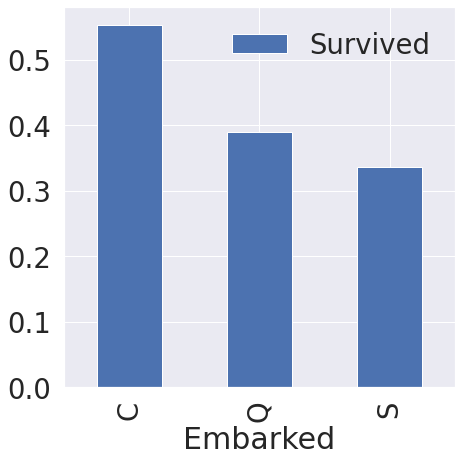

In [31]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending = False).plot.bar(ax=ax)

# c에서 탑승한 사람의 생존율이 높음

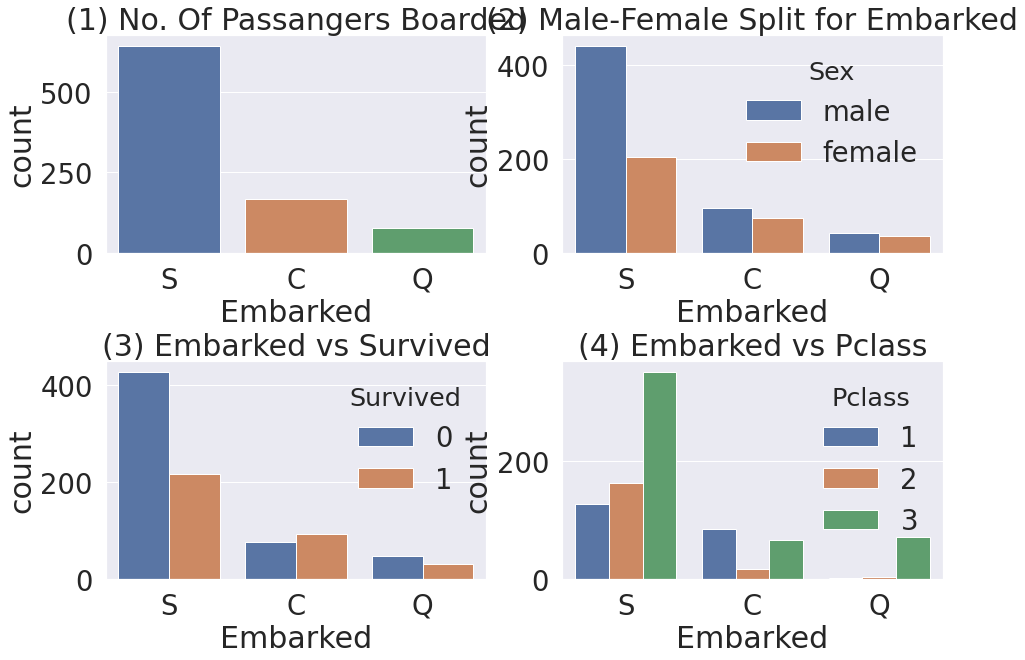

In [32]:
f,ax=plt.subplots(2, 2, figsize=(15,10))

# (1)
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passangers Boarded')

# (2)
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')

# (3)
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')

# (4)
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace = 0.5)
plt.show()

# (1) S 에서 가장 많은 사람이 탑승
# (2) C와 Q 는 남녀의 비율이 비슷하고, S는 남자가 더 많음
# (3) S인 경우 생존율이 낮음
# (4) pclass를 하니 C가 생존율 높은 이유는 클래스가 높은 사람이 많이 탔기 때문. S는 3등급이 많아서 생존율이 낮음

### 3.7 sibsp, parch에 따른 survived
- sibsp: 형제,자매
- parch: 부모,자녀
- sibsp와 parch를 합하면 Family가 됨

#### sibsp와 parch를 합하여 Family 칼럼 생성

In [33]:
df_train['Family']=df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family']=df_test['SibSp'] + df_test['Parch'] + 1
# 자기 자신을 포함해야 하니 1을 더함

In [34]:
print(df_train['Family'].max())  # 최대 가족 수
print(df_train['Family'].min())  # 최저 가족 수

11
1


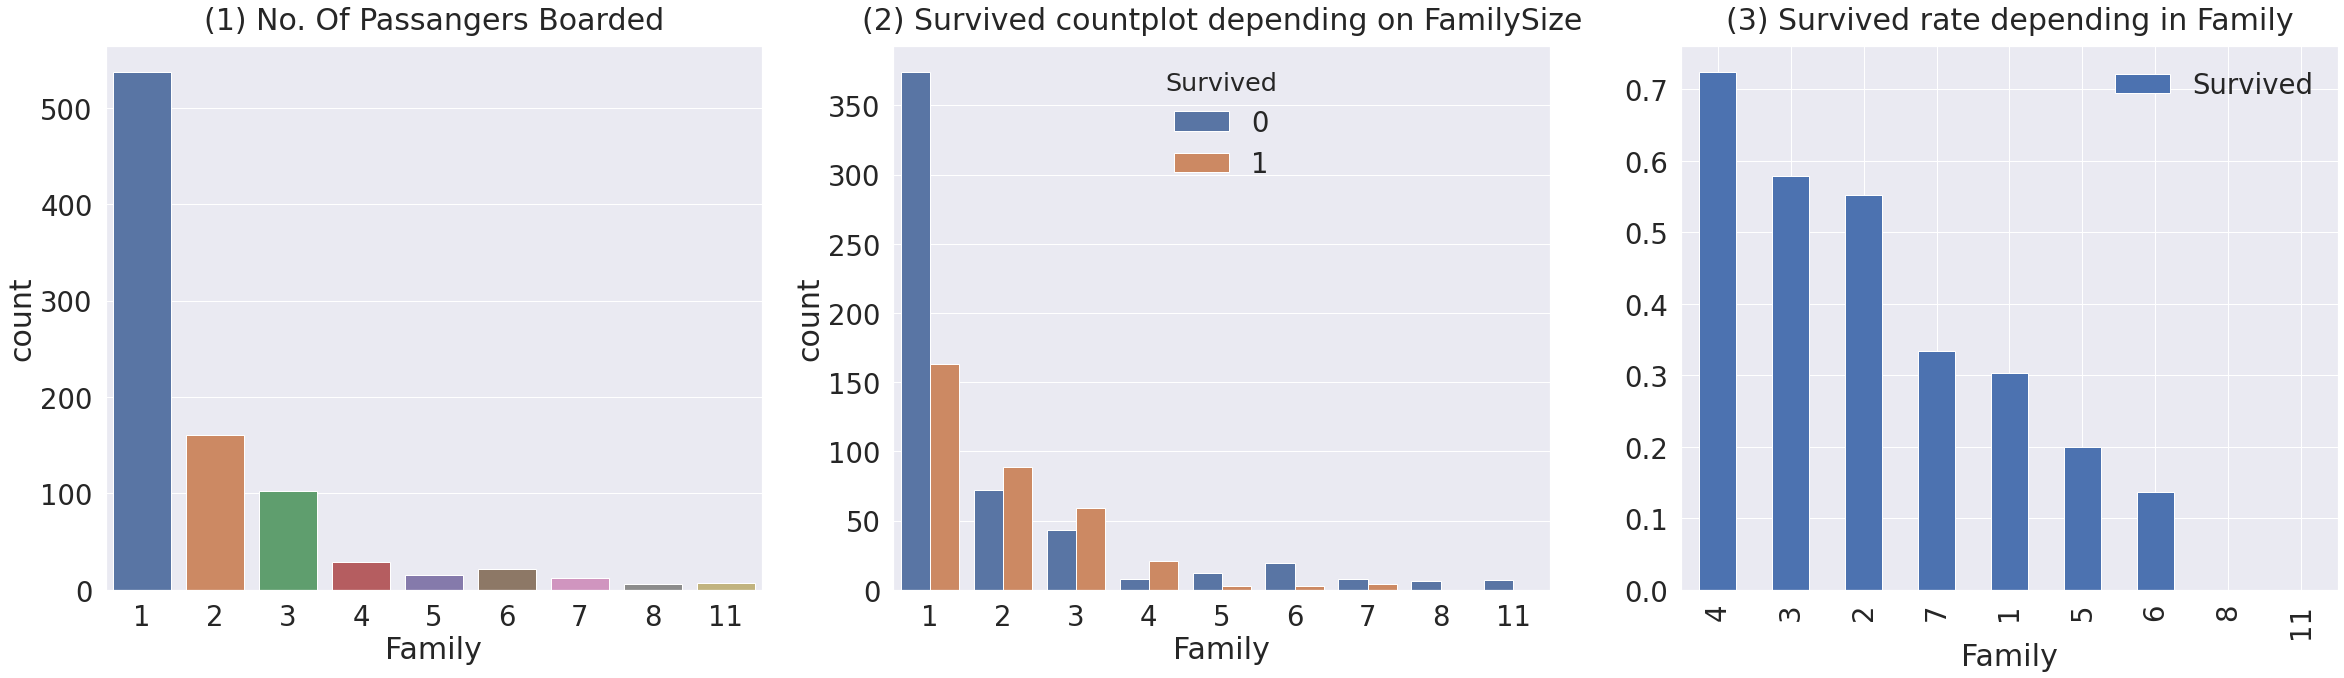

In [35]:
f,ax=plt.subplots(1, 3, figsize=(40,10))

# (1)
sns.countplot('Family', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passangers Boarded', y=1.02)

# (2)
sns.countplot('Family', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

# (3)
df_train[['Family', 'Survived']].groupby(['Family'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending in Family', y = 1.02)                                                                                                                                 

plt.subplots_adjust(wspace=0.2, hspace = 0.5)
plt.show()

# (1)보면 가족 수는 1명 ~ 11명까지 있음. 대부분이 1명이고 2,3,4명이 많음
# (2),(3)을 보면 가족 수가 4명일 때 생존율이 높고, 너무 많거나 적은 경우 생존율이 낮음

### 3.8 fare에 따른 survived

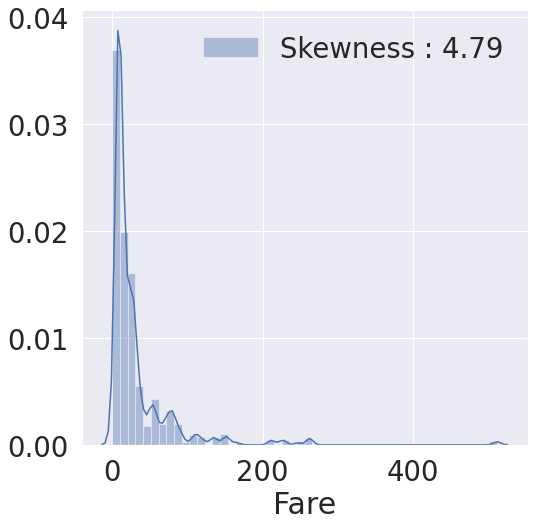

In [36]:
fug, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color = 'b', label = 'Skewness : {:.2f}'. format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc = 'best')

# 그래프를 보면 데이터 분포가 비대칭적인 것을 알 수 있음 -> 이 상태로 모델에 입력하면 학습이 잘 안됨
# 이상치의 영향을 줄여주기 위해 fare칼럼 데이터에 모두 log를 취해줌 -> 판다스의 map이나 apply를 사용하여 lambda함수를 인자로 넣어줌

#### fare에 log적용

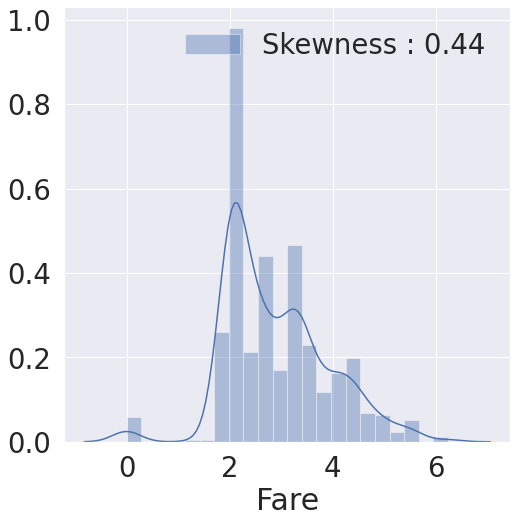

In [37]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset에 있는 null값을 평균값으로 치환

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(1, 1, figsize = (8,8))
g = sns.distplot(df_train['Fare'], color = 'b', label = 'Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc = 'best')

# 비대칭적인 부분이 완화됨

### 3.9 cabin에 따른 survived
- cabin 칼럼의 80%가 null이라 피처로 사용하지 않음

In [38]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


### 3.10 ticket에 따른 survived

In [39]:
df_train['Ticket'].value_counts()
# null값은 없지만 문자형이므로 전처리 필요
# 생존율과는 관계 없어보임

1601        7
347082      7
CA. 2343    7
CA 2144     6
347088      6
           ..
248731      1
13509       1
312991      1
11755       1
349254      1
Name: Ticket, Length: 681, dtype: int64

## 4. Feature engineering 
- 피처 엔지니어링은 실제 모델에 적용하는 것이므로 train과 test 모두 적용해야 함

### 4.1 Name
- 영어에는 Miss, Mrr, Mrs 같은 title이 존재함
- pandas에는 data를 string 으로 바꿔주는 str method와 여기에 정규표현식을 적용하게 해주는 extract method가 있음
- 이를 사용하여 title을 추출한 뒤, 새로운 Initial 칼럼에 저장하여 성별별 구분

#### 이름에 포함된 title 추출 

In [40]:
df_train['Name'].str  # 정규표현식 사용을 위해 Name 데이터 타입을 string으로 변환

#### extract 사용하여 정규표현식 적용

In [41]:
df_train['Name'].str.extract('([A-Za-z]+)\.')
# A~Z,a~z까지 하나라도 있고, .가 있는 것 출력

,0
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr
...,...
886,Rev
887,Miss
888,Miss
889,Mr


#### 추출한 title을 새로운 Initial 칼럼으로  train과 test에 추가

In [42]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.')

In [43]:
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')

#### Initial 칼럼 추가된 것 확인

In [44]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr


In [45]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,2,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,1,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,3,Mrs


#### crosstab을 통해 sex와 Initial간의 관계 확인

In [46]:
pd.crosstab(df_train['Initial'],df_train['Sex']).T.style.background_gradient(cmap = 'summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


####  crosstab을 참고하여 여자와 남자가 쓰는 Initial을 구분하여 치환

In [47]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

# inplace=True로 원본 데이터에 바로 적용

## 4.2 null값 채우기
- train에서 얻은 statistics를 기반으로 test의 null data를 채울 것
- Age: 각 연령대별 평균 나이로 대체
- Embarked: 가장 많은 값으로 대체

### Age 
- null값을 각 연령대별 평균 나이로 치환

In [48]:
df_train.groupby('Initial').mean() # 각 title별 평균나이 확인

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


#### Mr인 경우 Mr의 평균 나이로 null값 치환

In [49]:
df_train.loc[(df_train['Age'].isnull()) &(df_train['Initial']=='Mr'),'Age'] = 33
# Mr인 경우 평균나이가 32.79세이므로 33으로 채워줌

#### 나머지 연령대도 평균 나이로 변경

In [50]:
df_train.loc[(df_train['Age'].isnull()) &(df_train['Initial']=='Mrs'),'Age'] = 37
df_train.loc[(df_train['Age'].isnull()) &(df_train['Initial']=='Master'),'Age'] = 5
df_train.loc[(df_train['Age'].isnull()) &(df_train['Initial']=='Miss'),'Age'] = 22
df_train.loc[(df_train['Age'].isnull()) &(df_train['Initial']=='Other'),'Age'] = 45

In [51]:
df_test.loc[(df_test['Age'].isnull()) &(df_test['Initial']=='Mr'),'Age'] = 33
df_test.loc[(df_test['Age'].isnull()) &(df_test['Initial']=='Mrs'),'Age'] = 37
df_test.loc[(df_test['Age'].isnull()) &(df_test['Initial']=='Master'),'Age'] = 5
df_test.loc[(df_test['Age'].isnull()) &(df_test['Initial']=='Miss'),'Age'] = 22
df_test.loc[(df_test['Age'].isnull()) &(df_test['Initial']=='Other'),'Age'] = 45

#### null값 채워진것 확인

In [52]:
df_train['Age'].isnull().sum()

0

In [53]:
df_test['Age'].isnull().sum()

0

### Embarked 
- 가장 많은 데이터인 S로 치환

In [54]:
df_train['Embarked'].isnull().sum()

2

In [55]:
df_train.shape
# 891 데이터 중 null 값은 2개 뿐이므로 가장 많은 데이터로 치환

(891, 14)

#### fillna 사용하여 가장 많은 데이터인 S로 채워줌

In [56]:
df_train['Embarked'].fillna('S', inplace = True)
df_test['Embarked'].fillna('S', inplace = True)

#### null값 채워진것 확인

In [57]:
df_train['Embarked'].isnull().sum()

0

In [58]:
df_test['Embarked'].isnull().sum()

0

## 4.3 Type 변경
- Age: 연속적인 수치형을 카테고리형으로 변환
- Name: 문자형 ititial을 수치형으로 변환
- Embarked: 문자형을 수치형으로 변환
- Sex: 이진 문자형을 수치형으로 변환

### Age
- 연속적인 수치형을 카테고리형으로 변환

In [59]:
df_train['Age_cat'] = 0
# 카테고리형으로 변경한 데이터를 삽입할 칼럼 추가

In [60]:
df_train.head()  # Age_cat 칼럼 추가됨

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr,0


#### 4.3.1 loc 사용하여 카테고리형으로 변경

In [61]:
df_train.loc[df_train['Age']<10,'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[(70 <= df_train['Age']) , 'Age_cat'] = 7

In [62]:
df_test.loc[df_test['Age']<10,'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[(70 <= df_test['Age']) , 'Age_cat'] = 7

In [63]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr,3


In [64]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,1,Mr,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,2,Mrs,4.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,1,Mr,6.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,1,Mr,2.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,3,Mrs,2.0


#### 4.3.2 apply 함수 사용하여 카테고리형으로 변경

In [65]:
def category_age(x):
    if x < 10 :
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [66]:
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)
df_test['Age_cat_2'] = df_test['Age'].apply(category_age)

#### 두 가지 방법이 같은 결과로 나오는지 확인

In [67]:
(df_train['Age_cat'] == df_train['Age_cat_2']).all()
(df_test['Age_cat'] == df_test['Age_cat_2']).all()

# ()로 묶어주면 시리즈가 됨
# 전체가 같은지 확인할 때는 all사용

# all하면 모든 게 True일 때 True 나옴. 하나라도 True가 아니면 False
# any하면 하나라도 True가 있으면 True가 아님. True가 하나도 없으면 False

True

#### 위에서 임의로 만든 Age_cat_2 칼럼 drop

In [68]:
df_train.drop(['Age_cat_2'], axis =1, inplace = True)  # axis =1로 해주면 세로로 날아감df_test.drop(['Age_cat_2'], axis =1, inplace = True)
df_test.drop(['Age_cat_2'], axis =1, inplace = True) 

#### drop된 것 확인

In [69]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr,3


In [70]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,1,Mr,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,2,Mrs,4.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,1,Mr,6.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,1,Mr,2.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,3,Mrs,2.0


### Name
- 위에서 name칼럼을 정리한 initial칼럼은 문자형으로 이뤄져 있으므로 숫자형으로 변경

In [71]:
df_train.Initial.unique()
# mr는 1, mrs는 2 등으로 변경할 예정

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

#### map 사용하여 train과 test에 적용

In [72]:
df_train['Initial'] = df_train['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs': 3,'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs': 3,'Other':4})

In [73]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,3,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,2,3


In [74]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,1,2,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,2,3,4.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,1,2,6.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,1,2,2.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,3,3,2.0


### Embarked
- map을 사용하기 전에 어떤 값들이 있는지 먼저 확인

#### 4.3.1 unique 사용

In [75]:
df_train.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

#### 4.3.2 value counts 사용

In [76]:
df_train['Embarked'].value_counts()
# unique한 것의 개수까지 알 수 있음

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### map 사용하여 train과 test에 적용

In [77]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1,'S':2})

In [78]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,2,1,2,3


In [79]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,1,1,2,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,2,2,3,4.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,1,1,2,6.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,2,1,2,2.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,2,3,3,2.0


### Sex
- 이진 문자형으로 되어있는 것을 수치형으로 변환

In [80]:
df_train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [81]:
df_train['Sex'] = df_train['Sex'].map({'female':0,'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0,'male':1})

In [82]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,NaN,2,1,2,3


In [83]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Initial,Age_cat
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,2.057860,NaN,1,1,2,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1.945910,NaN,2,2,3,4.0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2.270836,NaN,1,1,2,6.0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2.159003,NaN,2,1,2,2.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2.508582,NaN,2,3,3,2.0


## 4.4 Pearson correalation
- 피처들간의 선형적 상관관계 알아봄
- 1이면 양의 선형관계, -1이면 반비례하는 음의 상관관계
- 0이면 선형관계 없음

#### 8개 피처들을 한번에 보기위해 heatmap사용

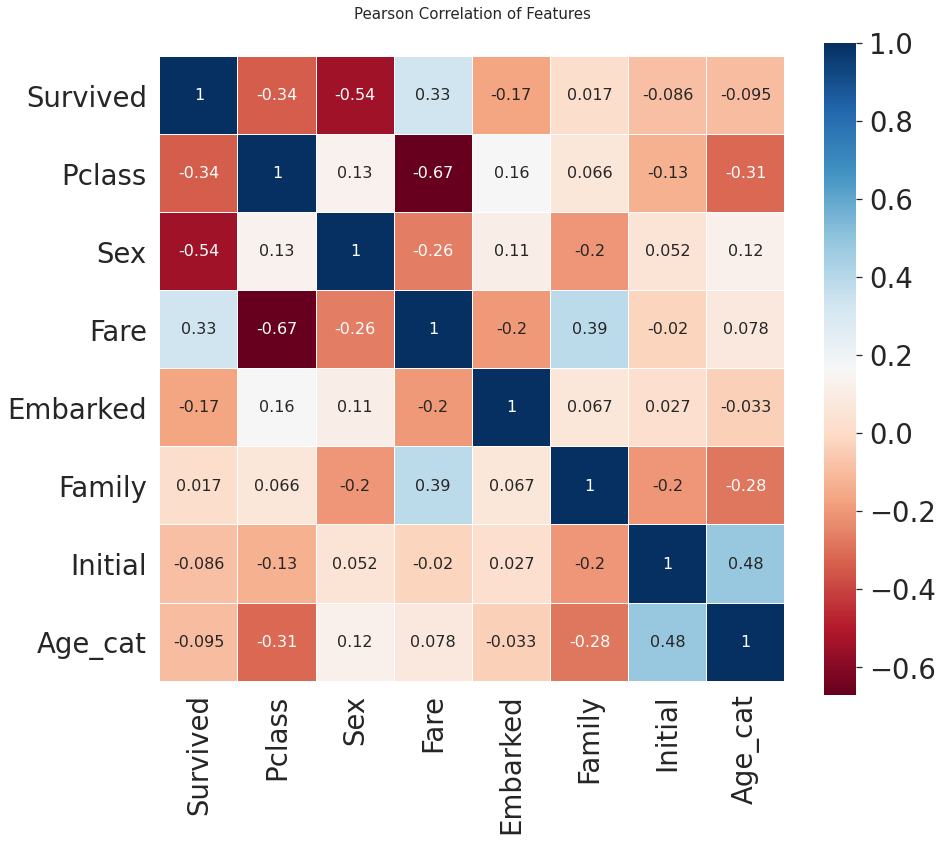

In [84]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Family', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

# astype(float): heatmap 데이터를 실수형으로 바꿔줌
# linewidths: 네모 칸 사이 라인의 크기
# vmax: 오른쪽 축
# linecolor: 네모 칸 사이 라인 색깔
# annot: 네모 칸 안에 숫자 표시
# annot_kws{'size':16}: 네모 칸 안에 숫자 크기
# fmt ='.2f': 네모 칸 안에 숫자 2번째 자리까지 반올림

# 우리목표는 Survived이니 x축의 survived 선택하고 y축 피처 마다의 계수를 보면 됨
# fare와 pclass의 계수가 1이라면 둘 중 하나의 피처만 선택해도 됨

## 4.5 One-hot encoding
- 수치화는 Master=0, Miss=1, Mr=2, Mrs=3, Other=4로 매핑해주는 것
- 원 핫 인코딩은 위 카테고리를 (0,1)로 이루어진 5차원의 벡터로 나타내주는 것
  - 총 5개의 카테고리이므로 새로운 5개의 칼럼이 생겨나게 됨
  - 판다스의 get_dummies사용

- Initial 
- Embarked

### Initial

In [85]:
df_train = pd.get_dummies(df_train,columns=['Initial'],prefix='Initial') # prefix=Initial: Initial 0, Initial 1 이렇게 구분하기 쉽게 나옴
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [86]:
df_test = pd.get_dummies(df_test,columns=['Initial'],prefix='Initial')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,2.057860,NaN,1,1,3.0,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1.945910,NaN,2,2,4.0,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2.270836,NaN,1,1,6.0,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2.159003,NaN,2,1,2.0,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2.508582,NaN,2,3,2.0,0,0,0,1,0



### Embarked

In [87]:
df_train = pd.get_dummies(df_train,columns=['Embarked'],prefix='Embarked')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,...,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,...,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,...,1,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,...,2,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,...,1,3,0,0,1,0,0,0,0,1


In [88]:
df_test = pd.get_dummies(df_test,columns=['Embarked'],prefix='Embarked')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,2.057860,NaN,1,3.0,0,0,1,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1.945910,NaN,2,4.0,0,0,0,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2.270836,NaN,1,6.0,0,0,1,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2.159003,NaN,1,2.0,0,0,1,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2.508582,NaN,3,2.0,0,0,0,1,0,0,0,1


## 4.6 불필요한 피처 제거
- Passengerid
- Name: Name대신 Initial칼럼을 만들었으므로 필요하지 않음
- SibSp + Parch: 두 칼럼을 합친 Family를 만들었으므로 필요하지 않음
- Ticket
- Cabin
- age: 카테고리형으로 변환한 age_cat칼럼 만들었으므로 필요하지 않음

In [89]:
df_train.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Age'],axis = 1,inplace = True)
df_test.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Age'],axis = 1,inplace = True)

In [90]:
df_train.head()

,Survived,Pclass,Sex,Fare,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [91]:
df_test.head()

,Pclass,Sex,Fare,Family,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3.0,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4.0,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6.0,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2.0,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2.0,0,0,0,1,0,0,0,1


## 5. modeling

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn import metrics # 모델의 평가

### 5.1 결정 트리

#### train 데이터 셋을 피처와 레이블 데이터 셋으로 분리

In [93]:
X_train = df_train.drop('Survived', axis=1)  # survived를 제외한 피처들
target_label = df_train['Survived']          # survived만 있는 피처

In [94]:
X_train.shape, target_label.shape

((891, 13), (891,))

#### 학습 데이터 셋과 테스트 데이터 셋으로 분리

In [95]:
X_train, X_val, y_train, y_val = train_test_split(X_train, target_label, test_size=0.2, random_state=11)

#### 결정 트리 학습/예측/평가 

In [96]:
dt = DecisionTreeClassifier(random_state=11)

# 학습
dt.fit(X_train , y_train)

# 예측
dt_pred = dt.predict(X_val)

# 평가
dt_accuracy = accuracy_score(y_val, dt_pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(dt_accuracy))

결정 트리 예측 정확도: 0.7877



#### GridSearchCV로 하이퍼 파라미터 튜닝


In [97]:
# 하이퍼 파라미터 설정
parameters = {'max_depth':[2,3,5,10],'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]} 

# 하이퍼 파라미터를 5개의 train, val로 나누어 테스트 수행 설정
grid_dt = GridSearchCV(dt, param_grid = parameters, scoring = 'accuracy', cv=5, verbose=1 , refit = True)  #  verbose: 얼마나 자세히 정보를 표시할 것인가 0,1,2로 나눠짐

# 튜닝된 하이퍼 파라미터로 학습
grid_dt.fit(X_train, y_train)

# 최고 성능을 낸 하이퍼 파라미터 값과 그때의 평가값 저장
print('GridSearchCV 최적 하이퍼 파라미터:', grid_dt.best_params_)       # 최적 하이퍼 파라미터
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_dt.best_score_))  # 최적 하이퍼 파라미터일 때 정확도

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도:0.8244


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.2s finished


#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행

In [98]:
# refit = True로 최적 하이퍼 파라미터 미리 학습하여 best_estimator_로 저장됨(별도로 fit할 필요없음)
dt1= grid_dt.best_estimator_   

# 재예측
dt1_pred = dt1.predict(X_val)   

# 재평가
dt1_accuracy = accuracy_score(y_val , dt1_pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(dt1_accuracy))

결정 트리 예측 정확도:0.8827



#### feaure_importances_사용하여 피처들의 중요도 확인

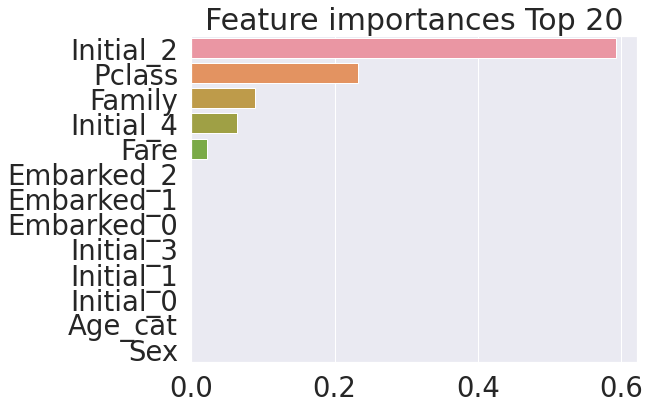

In [99]:
import seaborn as sns

ftr_importances_values = dt1.feature_importances_

# 정렬을 쉽게 하고, 막대그래프로 표현하기 위해 Series로 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )

# top20만 확인
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

# 그래프 설정
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)

plt.show()

### 5.2 랜덤포레스트

In [100]:
rf = RandomForestClassifier(random_state=11)

# 학습
rf.fit(X_train , y_train)

# 예측
rf_pred = rf.predict(X_val)

# 평가
rf_accuracy = accuracy_score(y_val ,rf_pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(rf_accuracy))

랜덤 포레스트 정확도: 0.8324


#### GridSearchCV로 하이퍼 파라미터 튜닝



In [101]:
# 하이퍼 파라미터 설정
parameters = {'n_estimators':[10], 'max_depth' : [6, 8, 10, 12], 'min_samples_leaf' : [8, 12, 18 ],'min_samples_split' : [8, 16, 20]}

# 하이퍼 파라미터를 2개의 train, val로 나누어 테스트 수행 설정
grid_rf = GridSearchCV(rf, param_grid = parameters , cv=2)     # 이번에는 refit 안해봄

# 튜닝된 하이퍼 파라미터로 학습
grid_rf.fit(X_train, y_train)

# 최고 성능을 낸 하이퍼 파라미터 값과 그때의 평가값 저장
print('최적 하이퍼 파라미터:\n', grid_rf.best_params_)           # 최적 하이퍼 파라미터
print('최고 예측 정확도: {0:.4f}'.format(grid_rf.best_score_))  # 최적 하이퍼 파라미터일 때 정확도

최적 하이퍼 파라미터:
 {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
최고 예측 정확도: 0.8132


#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행

In [102]:
# 최적 하이퍼 파라미터 적용
rf1 = RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=8, random_state=0)

# 재학습
rf1.fit(X_train , y_train)    # refit 안했으므로 fit도 수행

# 재예측
rf1_pred = rf1.predict(X_val)

# 재평가
print(accuracy_score(y_val , rf1_pred))

0.88268156424581



#### feaure_importances_사용하여 피처들의 중요도 확인

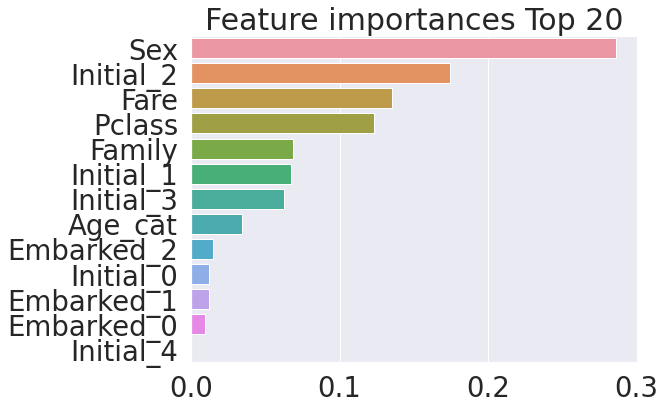

In [103]:
import seaborn as sns

ftr_importances_values = rf1.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 막대그래프로 쉽게 표현하기 위해  sort_values사용해 Series로 변환
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns) 

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]  # sort_values사용해 많은 피처들 중에 일부만 봄

# 그래프 설정
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### 5.3 보팅 분류기

In [104]:
# 개별 모델
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=11)

# 개별 모델을 보팅 방식으로 결합
vo = VotingClassifier( estimators=[('LR',lr),('RF',rf)] , voting='soft' )

# 학습
vo.fit(X_train , y_train)

# 예측
vo_pred = vo.predict(X_val)

# 평가
accuracy = accuracy_score(y_val , vo_pred)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy))

Voting 분류기 정확도: 0.8771


### 5.4 GBM

In [105]:
gbm = GradientBoostingClassifier(random_state=0)

# 학습
gbm.fit(X_train , y_train)

# 예측
gbm_pred = gbm.predict(X_val)

# 평가
gbm_accuracy = accuracy_score(y_val, gbm_pred)

print('GBM 정확도: {0:.4f}'.format(gbm_accuracy))

GBM 정확도: 0.8883


#### GridSearchCV로 하이퍼 파라미터 튜닝

In [106]:
# 하이퍼 파라미터 설정
parameters = {'n_estimators':[100, 500], 'learning_rate' : [ 0.05, 0.1]}   # 오래 걸리므로 많이 하지 않음

# 하이퍼 파라미터를 3개의 train, val로 나누어 테스트 수행 설정
grid_gbm = GridSearchCV(gbm , param_grid=parameters , cv=2 ,verbose=1, refit=True)     # cv도 2개만

# 튜닝된 하이퍼 파라미터로 학습
grid_gbm.fit(X_train , y_train)


# 최고 성능을 나타낸 하이퍼 파라미터의 값과 그때의 평가값 저장
print('최적 하이퍼 파라미터:\n', grid_gbm.best_params_)             # 최적 하이퍼 파라미터
print('최고 예측 정확도: {0:.4f}'.format(grid_gbm.best_score_))    # 최적 하이퍼 파라미터일 때 정확도

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.8272


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s finished


#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행

In [107]:
# refit = True로 최적 하이퍼 파라미터 미리 학습하여 best_estimator_로 저장됨(별도로 fit할 필요없음)
gbm1 = grid_gbm.best_estimator_

# 재예측
gbm1_pred = gbm1.predict(X_val)

# 재평가
gbm1_accuracy = accuracy_score(y_val, gbm1_pred)
print('GBM 정확도: {0:.4f}'.format(gbm1_accuracy))

GBM 정확도: 0.8771


#### feaure_importances_사용하여 피처들의 중요도 확인

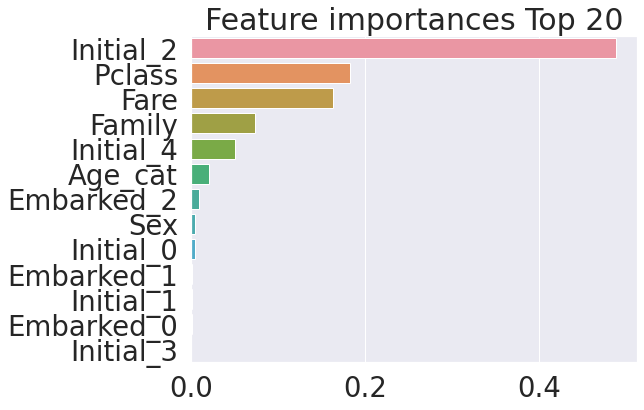

In [108]:
import seaborn as sns

ftr_importances_values = gbm1.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 막대그래프로 쉽게 표현하기 위해  sort_values사용해 Series로 변환
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns) 

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]  # sort_values사용해 많은 피처들 중에 일부만 봄

# 그래프 설정
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

### 5.5 XGBoost

In [109]:
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)   

# 원래 evalution데이터는 검증 데이터로 해야하는데 테스트 데이터로 하는 이유는 현재 데이터 수가 적어서
evals = [(X_val,y_val)]  

# 학습 (조기 중단 적용)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric= 'logloss', eval_set=evals, verbose=True)     # eval_metric는 성능 평가 방법, error/logloss 적용
                                                                                                               # eval_set: 성능 평가를 수행할 평가용 데이터 설정                     
# 예측
#xgb_pred = xgb.predict(X_val)
xgb_pred_proba = xgb.predict_proba(X_val)[:, 1]  #  0일 확률과 1일 확률중 생존확률인 1일 확률만 출력함


#threshold = 0.5  
#xgb_pred_proba= pred_proba[:,1].reshape(-1,1)

#binarizer = Binarizer(threshold=0.5).fit(xgb_pred_proba)           
#pred=binarizer.transform(xgb_pred_proba))


# 평가
xgb_accuracy = accuracy_score(y_val,xgb_pred_proba)   
print('accuracy: {0:.4f}'.format(xgb_accuracy))

[0]	validation_0-logloss:0.64201
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.59967
[2]	validation_0-logloss:0.56419
[3]	validation_0-logloss:0.53311
[4]	validation_0-logloss:0.50659
[5]	validation_0-logloss:0.48423
[6]	validation_0-logloss:0.46457
[7]	validation_0-logloss:0.44844
[8]	validation_0-logloss:0.43420
[9]	validation_0-logloss:0.42171
[10]	validation_0-logloss:0.41064
[11]	validation_0-logloss:0.40113
[12]	validation_0-logloss:0.39282
[13]	validation_0-logloss:0.38544
[14]	validation_0-logloss:0.37943
[15]	validation_0-logloss:0.37378
[16]	validation_0-logloss:0.36863
[17]	validation_0-logloss:0.36420
[18]	validation_0-logloss:0.36053
[19]	validation_0-logloss:0.35782
[20]	validation_0-logloss:0.35435
[21]	validation_0-logloss:0.35235
[22]	validation_0-logloss:0.35095
[23]	validation_0-logloss:0.34878
[24]	validation_0-logloss:0.34614
[25]	validation_0-logloss:0.34521
[26]	validation_0-logloss:0.34411
[27]	validation_0-loglo

ValueError: Classification metrics can't handle a mix of binary and continuous targets


#### GridSearchCV로 하이퍼 파라미터 튜닝


In [110]:
# 하이퍼 파라미터 설정
parameters = {'max_depth':[5, 7] , 'min_child_weight':[1,3] }   

# 원래 evalution 데이터는 검증 데이터로 해야하는데 테스트 데이터로 하는 이유는 현재 데이터 수가 적어서
evals = [(X_val,y_val)]  

# 하이퍼 파라미터를 3개의 train, val로 나누어 테스트 수행 설정
grid_xgb = GridSearchCV(xgb, param_grid=parameters, cv=3)

# 튜닝된 하이퍼 파라미터로 학습
grid_xgb.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='logloss', eval_set=evals)

# 튜닝된 하이퍼 파라미터로 예측
grid_xgb_pred = xgb.predict(X_val)
grid_xgb_pred_proba = xgb.predict_proba(X_val)[:, 1]

# 최고 성능을 나타낸 하이퍼 파라미터의 값과 그때의 평가값 저장
grid_xgb_accuracy = accuracy_score(y_val, grid_xgb_pred_proba)   

print('최적 하이퍼 파라미터:\n', grid_xgb.best_params_)     # 최적 하이퍼 파라미터
print('accuracy: {0:.4f}'.format(grid_xgb_accuracy))     # 최적 하이퍼 파라미터일 때 정확도

[0]	validation_0-logloss:0.64079
Will train until validation_0-logloss hasn't improved in 30 rounds.
[1]	validation_0-logloss:0.59918
[2]	validation_0-logloss:0.56219
[3]	validation_0-logloss:0.53384
[4]	validation_0-logloss:0.50767
[5]	validation_0-logloss:0.48641
[6]	validation_0-logloss:0.46829
[7]	validation_0-logloss:0.45223
[8]	validation_0-logloss:0.43913
[9]	validation_0-logloss:0.42904
[10]	validation_0-logloss:0.41962
[11]	validation_0-logloss:0.41113
[12]	validation_0-logloss:0.40448
[13]	validation_0-logloss:0.39813
[14]	validation_0-logloss:0.39199
[15]	validation_0-logloss:0.38608
[16]	validation_0-logloss:0.38164
[17]	validation_0-logloss:0.37905
[18]	validation_0-logloss:0.37623
[19]	validation_0-logloss:0.37364
[20]	validation_0-logloss:0.37036
[21]	validation_0-logloss:0.36847
[22]	validation_0-logloss:0.36825
[23]	validation_0-logloss:0.36689
[24]	validation_0-logloss:0.36557
[25]	validation_0-logloss:0.36515
[26]	validation_0-logloss:0.36412
[27]	validation_0-loglos

ValueError: Classification metrics can't handle a mix of binary and continuous targets

#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행

In [111]:
# 최적 하이퍼 파라미터 적용
xgb1 = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 원래 evalution 데이터는 검증 데이터로 해야하는데 테스트 데이터로 하는 이유는 현재 데이터 수가 적어서
evals = [(X_val,y_val)]  

# 재학습
xgb1.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='logloss',eval_set=evals)

# 재예측                                                                                                                             
xgb1_pred = xgb1.predict(X_val)
xgb1_pred_proba = xgb1.predict_proba(X_val)[:, 1]

# 재평가
xgb1_accuracy = accuracy_score(y_val, xgb1_pred_proba)   
print('accuracy: {0:.4f}'.format(xg1b_accuracy))

[0]	validation_0-logloss:0.68254
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.67275
[2]	validation_0-logloss:0.66342
[3]	validation_0-logloss:0.65356
[4]	validation_0-logloss:0.64372
[5]	validation_0-logloss:0.63467
[6]	validation_0-logloss:0.62652
[7]	validation_0-logloss:0.61776
[8]	validation_0-logloss:0.60960
[9]	validation_0-logloss:0.60201
[10]	validation_0-logloss:0.59571
[11]	validation_0-logloss:0.58855
[12]	validation_0-logloss:0.58157
[13]	validation_0-logloss:0.57504
[14]	validation_0-logloss:0.56919
[15]	validation_0-logloss:0.56272
[16]	validation_0-logloss:0.55646
[17]	validation_0-logloss:0.55052
[18]	validation_0-logloss:0.54488
[19]	validation_0-logloss:0.53873
[20]	validation_0-logloss:0.53316
[21]	validation_0-logloss:0.52800
[22]	validation_0-logloss:0.52348
[23]	validation_0-logloss:0.51808
[24]	validation_0-logloss:0.51444
[25]	validation_0-logloss:0.50978
[26]	validation_0-logloss:0.50547
[27]	validation_0-loglo

ValueError: Classification metrics can't handle a mix of binary and continuous targets


#### feaure_importances_사용하여 피처들의 중요도 확인


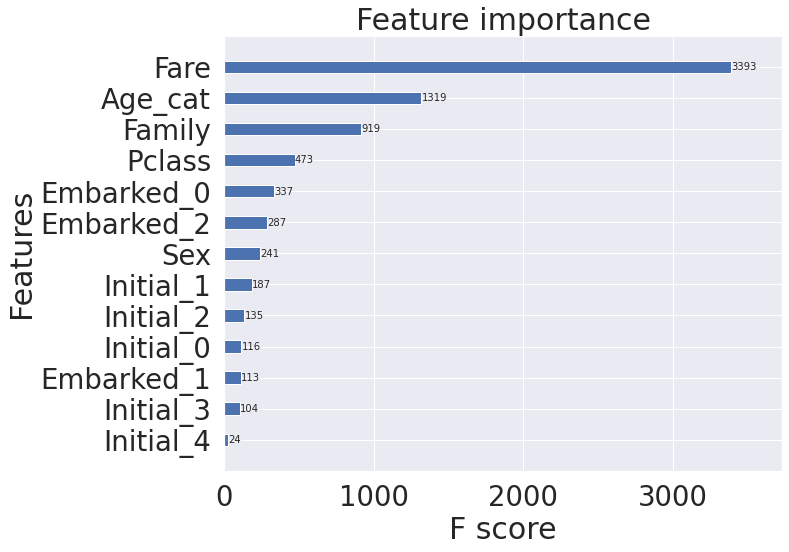

In [112]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb1, ax=ax , max_num_features=20,height=0.4)

# 칼럼이름이 나오는 이유는 numpy가 아닌 dataframe으로 했기 때문

### 5.6 LightGBM

In [113]:
lgbm = LGBMClassifier(n_estimators=400)

# evalution 세트는 검증 데이터 세트므로 테스트 데이터 사용하면 안됨(모의고사봐야하는데 본고사보면 안됨)
evals = [(X_val, y_val)]  

# 학습
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)

# 예측
lgbm_pred = lgbm.predict(X_val)
lgbm_pred_proba = lgbm.predict_proba(X_val)[:, 1]

# 평가
lgbm_accuracy = accuracy_score(y_val, lgbm_pred_proba)
print('accuracy: {0:.4f}'.format(lgbm_accuracy))

[1]	valid_0's binary_logloss: 0.601816
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.56296
[3]	valid_0's binary_logloss: 0.53082
[4]	valid_0's binary_logloss: 0.505524
[5]	valid_0's binary_logloss: 0.48151
[6]	valid_0's binary_logloss: 0.460714
[7]	valid_0's binary_logloss: 0.44325
[8]	valid_0's binary_logloss: 0.427682
[9]	valid_0's binary_logloss: 0.416513
[10]	valid_0's binary_logloss: 0.405118
[11]	valid_0's binary_logloss: 0.396474
[12]	valid_0's binary_logloss: 0.389424
[13]	valid_0's binary_logloss: 0.383204
[14]	valid_0's binary_logloss: 0.376692
[15]	valid_0's binary_logloss: 0.371514
[16]	valid_0's binary_logloss: 0.366705
[17]	valid_0's binary_logloss: 0.362244
[18]	valid_0's binary_logloss: 0.358712
[19]	valid_0's binary_logloss: 0.356467
[20]	valid_0's binary_logloss: 0.354504
[21]	valid_0's binary_logloss: 0.35213
[22]	valid_0's binary_logloss: 0.350818
[23]	valid_0's binary_logloss: 0.349295
[24]	valid_0's binary_logloss: 0

ValueError: Classification metrics can't handle a mix of binary and continuous targets


#### GridSearchCV로 하이퍼 파라미터 튜닝

In [114]:
# 하이퍼 파라미터 설정
parameters = {'num_leaves': [32, 64 ],'max_depth':[128, 160],'min_child_samples':[60, 100], 'subsample':[0.8, 1]}   # num_leaves: 하나의 트리가 가질수있는 최대 리프 개수
                                                                                                                # sumbsample: 과적합 방지로 데이터 샘플링하는 비율
                                                                                                                # min_child_samples: 리프 노드가 되기 위해 최소로 필요한 레코드 수, 과적합 방지
# evalution 세트는 검증 데이터 세트므로 테스트 데이터 사용하면 안됨(모의고사봐야하는데 본고사보면 안됨)
evals = [(X_val, y_val)] 

# 하이퍼 파라미터를 2개의 train, val로 나누어 테스트 수행 설정
grid_lgbm = GridSearchCV(lgbm, param_grid=parameters, cv=2)


# 하이퍼 파라미터로 학습과 평가
grid_lgbm.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='logloss', eval_set=evals)

# 예측
grid_lgbm_pred = grid_lgbm.predict(X_val)
grid_lgbm_pred_proba = grid_lgbm.predict_proba(X_val)[:, 1]

# 평가
grid_lgbm_accuracy = accuracy_score(y_val, grid_lgbm_pred_proba)
print('accuracy: {0:.4f}'.format(grid_lgbm_accuracy))

[1]	valid_0's binary_logloss: 0.61353
Training until validation scores don't improve for 30 rounds
[2]	valid_0's binary_logloss: 0.58557
[3]	valid_0's binary_logloss: 0.555483
[4]	valid_0's binary_logloss: 0.530601
[5]	valid_0's binary_logloss: 0.514613
[6]	valid_0's binary_logloss: 0.496307
[7]	valid_0's binary_logloss: 0.485082
[8]	valid_0's binary_logloss: 0.471309
[9]	valid_0's binary_logloss: 0.459607
[10]	valid_0's binary_logloss: 0.453184
[11]	valid_0's binary_logloss: 0.444201
[12]	valid_0's binary_logloss: 0.43979
[13]	valid_0's binary_logloss: 0.43279
[14]	valid_0's binary_logloss: 0.426831
[15]	valid_0's binary_logloss: 0.42473
[16]	valid_0's binary_logloss: 0.419843
[17]	valid_0's binary_logloss: 0.415879
[18]	valid_0's binary_logloss: 0.414795
[19]	valid_0's binary_logloss: 0.411461
[20]	valid_0's binary_logloss: 0.40828
[21]	valid_0's binary_logloss: 0.40578
[22]	valid_0's binary_logloss: 0.40317
[23]	valid_0's binary_logloss: 0.401875
[24]	valid_0's binary_logloss: 0.399

ValueError: Classification metrics can't handle a mix of binary and continuous targets

#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행


In [115]:
lgbm1 = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,max_depth=128)

evals = [(X_val, y_val)]

# 재학습
lgbm1.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

# 재예측
lgbm1_pred = lgbm1.predict(X_val)
lgbm1_pred_proba = lgbm1.predict_proba(X_val)[:, 1]

# 평가
lgbm1_accuracy = accuracy_score(y_val, lgbm1_pred_proba)
print('accuracy: {0:.4f}'.format(lgbm1_accuracy))

[1]	valid_0's auc: 0.881773	valid_0's binary_logloss: 0.606703
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.881773	valid_0's binary_logloss: 0.573322
[3]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.546483
[4]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.522879
[5]	valid_0's auc: 0.889553	valid_0's binary_logloss: 0.503645
[6]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.486355
[7]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.472275
[8]	valid_0's auc: 0.889969	valid_0's binary_logloss: 0.459332
[9]	valid_0's auc: 0.890386	valid_0's binary_logloss: 0.44822
[10]	valid_0's auc: 0.889692	valid_0's binary_logloss: 0.438935
[11]	valid_0's auc: 0.889692	valid_0's binary_logloss: 0.430484
[12]	valid_0's auc: 0.890039	valid_0's binary_logloss: 0.423574
[13]	valid_0's auc: 0.888511	valid_0's binary_logloss: 0.417594
[14]	valid_0's auc: 0.888719	valid_0's binary_logloss: 0.411392
[15]	valid_0's auc: 0.888997	valid_0's binary_loglos

ValueError: Classification metrics can't handle a mix of binary and continuous targets

#### feaure_importances_사용하여 피처들의 중요도 확인


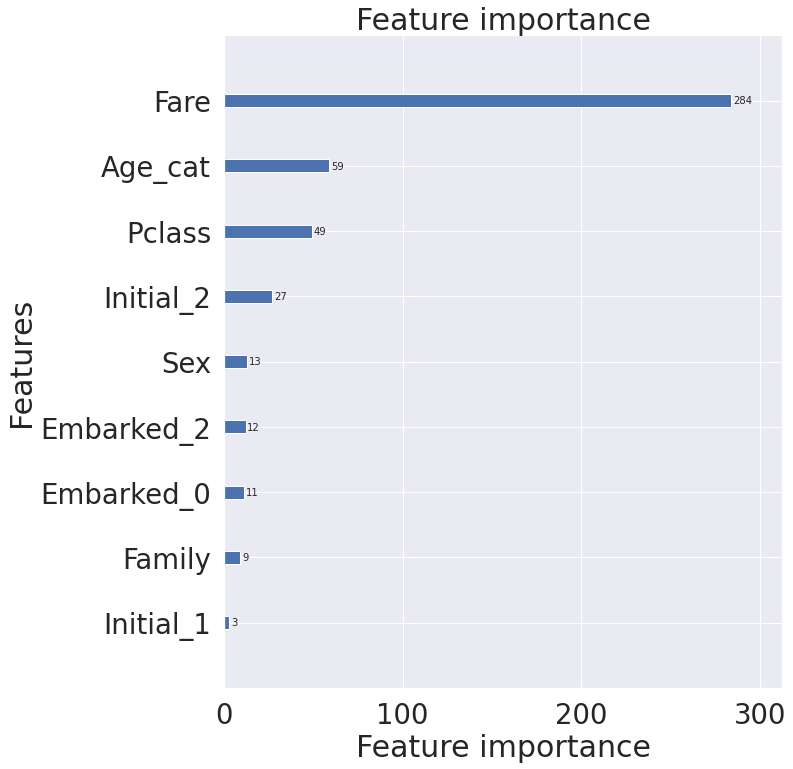

In [116]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm1, ax=ax)  # ax로 축도 가져옴, 학습이 완료된 lgbm_wrapper가져옴

# Column_1은 두번째 열 -> 데이터가 numpy라 칼럼명을 알 수 없어 순서로 알려줌

### 5.7 스태킹 앙상블

#### 개별 classifier와 최종 stacking 데이터를 학습할 메타 classifier 생성


In [117]:
# 개별 ML 모델을 위한 Classifier 생성
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=100, random_state=0)
gbm = GradientBoostingClassifier(random_state=0)
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)  
lgbm = LGBMClassifier(n_estimators=400)

# 최종 Stacking 모델을 위한 Classifier는 로지스틱 회귀 
lr_final = LogisticRegression(C=10)

#### 개별 classifier 학습/예측/평가

In [118]:
# 개별 모델들을 학습
dt.fit(X_train, y_train)
rf.fit(X_train , y_train)
gbm.fit(X_train , y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=400)

In [119]:
# 학습된 개별 모델을 예측하고 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정
dt_pred = dt.predict(X_val)
rf_pred = rf.predict(X_val)
gbm_pred = gbm.predict(X_val)
xgb_pred = xgb.predict(X_val)
lgbm_pred = lgbm.predict(X_val)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_val, dt_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_val, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_val, gbm_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_val, xgb_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_val, lgbm_pred)))

KNN 정확도: 0.7821
랜덤 포레스트 정확도: 0.8101
결정 트리 정확도: 0.8883
에이다부스트 정확도: 0.8603 :
에이다부스트 정확도: 0.8771 :


#### 개별 모델의 예측 결과를 메타 모델이 학습할 수 있도록 스태킹 형태로 재생성


In [120]:
# 위에서 나온 5개 모델을 가로로 먼저 쌓음
pred = np.array([dt_pred, rf_pred, gbm_pred, xgb_pred, lgbm_pred])
print(pred.shape)

# 가로로 쌓은 모델을 세로로 쌓기 위해 transpose를 이용해 행과 열 위치 변경
# 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

# 가로로 만들어진 모델의 행과 위치 바꿈

(5, 179)
(179, 5)


#### 메타 모델 학습/예측/평가


In [121]:
# 학습을 테스트로 하여 과적합 됨, 위에서도 이렇게 함 -> 이를 해결하기 위해 CV사용함
lr_final.fit(pred, y_val) 
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_val , final)))

최종 메타 모델의 예측 정확도: 0.8883


### 5.8 로지스틱 회귀

In [122]:
lr = LogisticRegression()

# 학습
lr.fit(X_train , y_train)

# 예측
lr_pred = lr.predict(X_val)

# 평가
accuracy = accuracy_score(y_val, lr_pred)
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, lr_pred)))

accuracy: 0.888


#### GridSearchCV로 하이퍼 파라미터 튜닝

In [123]:
# 하이퍼 파라미터 설정
parameters={'penalty':['l2', 'l1'],'C':[0.01, 0.1, 1, 1, 5, 10]}  # c는 작을수록 규제가 큼

# 하이퍼 파라미터를 3개의 train, val로 나누어 테스트 수행 설정
grid_lr = GridSearchCV(lr, param_grid=parameters, scoring='accuracy', cv=3 , refit= True)

# 튜닝된 하이퍼 파라미터로 학습
grid_lr.fit(X_train , y_train)

# 최고 성능을 낸 하이퍼 파라미터 값과 그때의 평가값 저장
print('GridSearchCV 최적 하이퍼 파라미터:', grid_lr.best_params_)       # 최적 하이퍼파라미터
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_lr.best_score_))  # 최적 하이퍼파라미터일 때 정확도

GridSearchCV 최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}
GridSearchCV 최고 정확도:0.8146


#### GridSearchCV로 얻은 최적 하이퍼 파리미터를 적용하여 학습/예측/평가 재수행

In [124]:
# refit = True로 최적 하이퍼 파라미터 미리 학습하여 best_estimator_로 저장됨(별도로 fit할 필요없음)
lr1 = grid_lr.best_estimator_   

# 재예측
lr1_pred = lr1.predict(X_val)         

# 재평가
lr1_accuracy = accuracy_score(y_val , lr1_pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(lr1_accuracy))

결정 트리 예측 정확도:0.8883


### 5.6 결과 제출

In [125]:
prediction = lr_final.predict(X_val)  # 학습한 걸 바탕으로 val데이터로 예측해봄
prediction

ValueError: X has 13 features per sample; expecting 5

In [126]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [127]:
prediction = lr_final.predict(X_test)  # 실제 예측
submission['Survived'] = prediction

NameError: name 'X_test' is not defined

In [128]:
submission['Survived'] = prediction  # survived에 내가 실제로 예측한걸 저장

NameError: name 'prediction' is not defined

In [129]:
submission.to_csv('submission.csv', index = False)  # 캐글 커널 서버에 csv파일 저장